#  Task 1: FedSGD vs Centralized SGD (Theoretical Equivalence) 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import copy, time, random, numpy as np, os
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
import random

# Config 
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)


M = 3   # number of clients
TOTAL_SAMPLES = 15000   
TRAIN_FRAC = 0.8
LR = 0.05               
NUM_ROUNDS = 40          
VAL_BATCH = 256

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})

DEVICE: cuda


### Small 3-layer network

In [3]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=8, num_channels=32)
        # conv block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=8, num_channels=64)
        # conv block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3   = nn.GroupNorm(num_groups=8, num_channels=128)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(128 * 8 * 8, 256)
        self.fc2   = nn.Linear(256, num_classes)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GroupNorm):
                if m.weight is not None:
                    nn.init.ones_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.gn1(self.conv1(x)))
        x = self.pool(x)   # 32->16
        x = F.relu(self.gn2(self.conv2(x)))
        x = self.pool(x)   # 16->8
        x = F.relu(self.gn3(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Utilities
def params_to_vector_cpu(model):
    return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def model_l2_diff(a, b):
    return torch.norm(params_to_vector_cpu(a) - params_to_vector_cpu(b)).item()

def evaluate(model, X_val, y_val, device=DEVICE, batch_size=VAL_BATCH):
    model.eval()
    loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    total_loss, total, correct = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            total_loss += loss_fn(logits, yb).item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss / total, correct / total

def compute_full_gradient_cpu(model, X_local, y_local, device=DEVICE):
    model.train()
    model.zero_grad()
    xb, yb = X_local.to(device), y_local.to(device)
    logits = model(xb)
    loss = nn.CrossEntropyLoss(reduction='mean')(logits, yb)
    loss.backward()
    grads = [p.grad.detach().cpu().clone() for p in model.parameters()]
    return grads, loss.item()

def print_param_snippet(name, model, n=6):
    v = params_to_vector_cpu(model)
    print(f"  [{name}] norm={v.norm().item():.6f}  first{n}={v[:n].numpy()}")


### Data loading (CIFAR-10 subset)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset    = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

indices = np.arange(len(train_full))
np.random.shuffle(indices)
sel = indices[:TOTAL_SAMPLES]
X = torch.stack([train_full[i][0] for i in sel])
y = torch.tensor([train_full[i][1] for i in sel], dtype=torch.long)

perm = torch.randperm(TOTAL_SAMPLES)
n_train = int(TOTAL_SAMPLES * TRAIN_FRAC)
train_idx = perm[:n_train]
val_idx   = perm[n_train:]
X_train = X[train_idx].clone(); y_train = y[train_idx].clone()
X_val   = X[val_idx].clone();   y_val   = y[val_idx].clone()

# IID split across clients 
n_train = X_train.size(0)
per_client = n_train // M
client_data = []
for i in range(M):
    s = i * per_client
    e = (i+1)*per_client if i < M-1 else n_train
    client_data.append((X_train[s:e].clone(), y_train[s:e].clone()))
print("client sizes:", [cd[0].size(0) for cd in client_data])
print("val size:", X_val.size(0))

client sizes: [4000, 4000, 4000]
val size: 3000


### Experiment

In [8]:
# Initialize identical models 
init_model = SmallCNN()
init_state = copy.deepcopy(init_model.state_dict())

central = SmallCNN().to(DEVICE); central.load_state_dict(copy.deepcopy(init_state))
fed_global = SmallCNN().to(DEVICE); fed_global.load_state_dict(copy.deepcopy(init_state))

print("Initial param snippet:")
print_param_snippet("central_init", central)
print_param_snippet("fed_init", fed_global)

# Training loop 
history = {'central_loss':[], 'central_acc':[], 'fed_loss':[], 'fed_acc':[], 'param_diff':[]}
start = time.time()
for r in range(1, NUM_ROUNDS + 1):
    #  Central full-gradient
    central.train(); central.zero_grad()
    xb_all = X_train.to(DEVICE); yb_all = y_train.to(DEVICE)
    logits = central(xb_all)
    loss_c = nn.CrossEntropyLoss(reduction='mean')(logits, yb_all)
    loss_c.backward()
    central_grads = [p.grad.detach().cpu().clone() for p in central.parameters()]
    with torch.no_grad():
        for p, g in zip(central.parameters(), central_grads):
            p.data = p.data - LR * g.to(p.device)

    #  Fed: each client computes gradient at fed_global weights
    client_grads = []
    client_ns = []
    for (Xc, yc) in client_data:
        client_model = SmallCNN().to(DEVICE)
        client_model.load_state_dict(copy.deepcopy(fed_global.state_dict()))
        grads, _ = compute_full_gradient_cpu(client_model, Xc, yc, device=DEVICE)
        client_grads.append(grads)
        client_ns.append(Xc.size(0))

    N_total = float(sum(client_ns))
    avg_grads = []
    for p_idx in range(len(client_grads[0])):
        stacked = torch.stack([client_grads[c][p_idx] * (client_ns[c] / N_total) for c in range(M)], dim=0)
        avg = torch.sum(stacked, dim=0)
        avg_grads.append(avg)

    with torch.no_grad():
        for p, g in zip(fed_global.parameters(), avg_grads):
            p.data = p.data - LR * g.to(p.device)

    # Evaluation
    closs_val, cacc_val = evaluate(central, X_val, y_val)
    floss_val, facc_val = evaluate(fed_global, X_val, y_val)
    diff = model_l2_diff(central, fed_global)

    history['central_loss'].append(closs_val); history['central_acc'].append(cacc_val)
    history['fed_loss'].append(floss_val); history['fed_acc'].append(facc_val)
    history['param_diff'].append(diff)

    elapsed = time.time() - start
    print(f"Round {r:02d}/{NUM_ROUNDS}  central_acc={cacc_val:.4f}  fed_acc={facc_val:.4f}  "
          f"central_loss={closs_val:.4f}  fed_loss={floss_val:.4f}  ||θc-θf||={diff:.6e}  elapsed={elapsed:.1f}s")
    print_param_snippet("central", central)
    print_param_snippet("fed", fed_global)

print("Total elapsed (s):", time.time() - start)

os.makedirs("fedsgd_results", exist_ok=True)
torch.save(history, "fedsgd_results/history.pt")


Initial param snippet:
  [central_init] norm=34.678638  first6=[-0.06226698 -0.00219162  0.32320067 -0.11029132  0.13889797  0.21628098]
  [fed_init] norm=34.678638  first6=[-0.06226698 -0.00219162  0.32320067 -0.11029132  0.13889797  0.21628098]
Round 01/40  central_acc=0.0943  fed_acc=0.0943  central_loss=7.6124  fed_loss=7.6124  ||θc-θf||=1.436901e-06  elapsed=1.2s
  [central] norm=34.683910  first6=[-0.06207619 -0.00209384  0.3230797  -0.11041187  0.13879171  0.21594064]
  [fed] norm=34.683910  first6=[-0.06207618 -0.00209385  0.3230797  -0.11041187  0.13879171  0.21594062]
Round 02/40  central_acc=0.1003  fed_acc=0.1003  central_loss=17.7761  fed_loss=17.7761  ||θc-θf||=5.458018e-06  elapsed=2.4s
  [central] norm=34.724579  first6=[-0.05974333 -0.00050978  0.32429433 -0.10897967  0.13997483  0.21642432]
  [fed] norm=34.724579  first6=[-0.05974327 -0.00050971  0.3242944  -0.10897973  0.13997482  0.21642429]
Round 03/40  central_acc=0.1080  fed_acc=0.1080  central_loss=11.0857  fed_

Saved plots to fedsgd_results/*.png


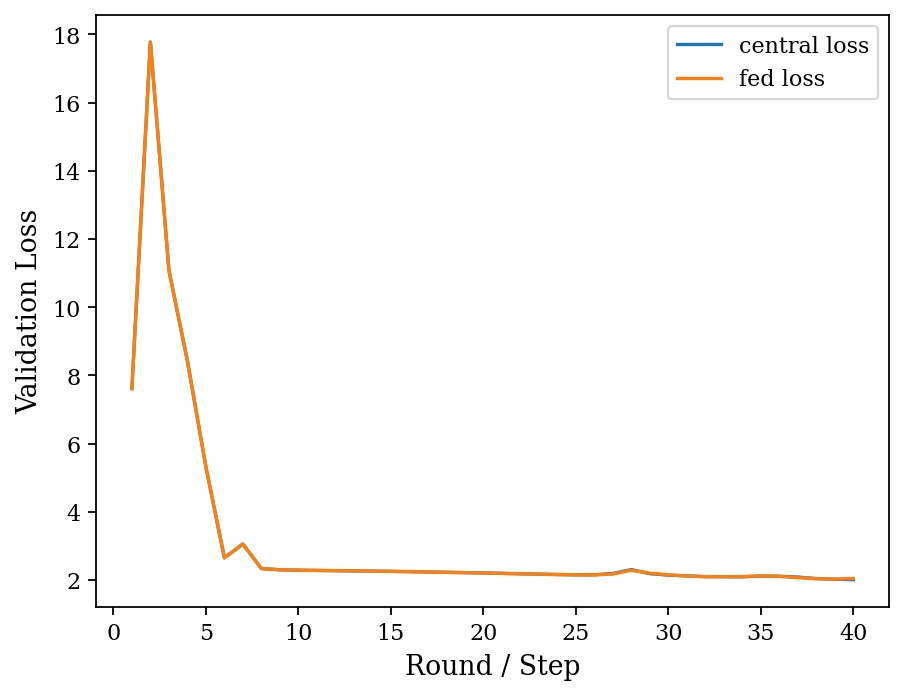

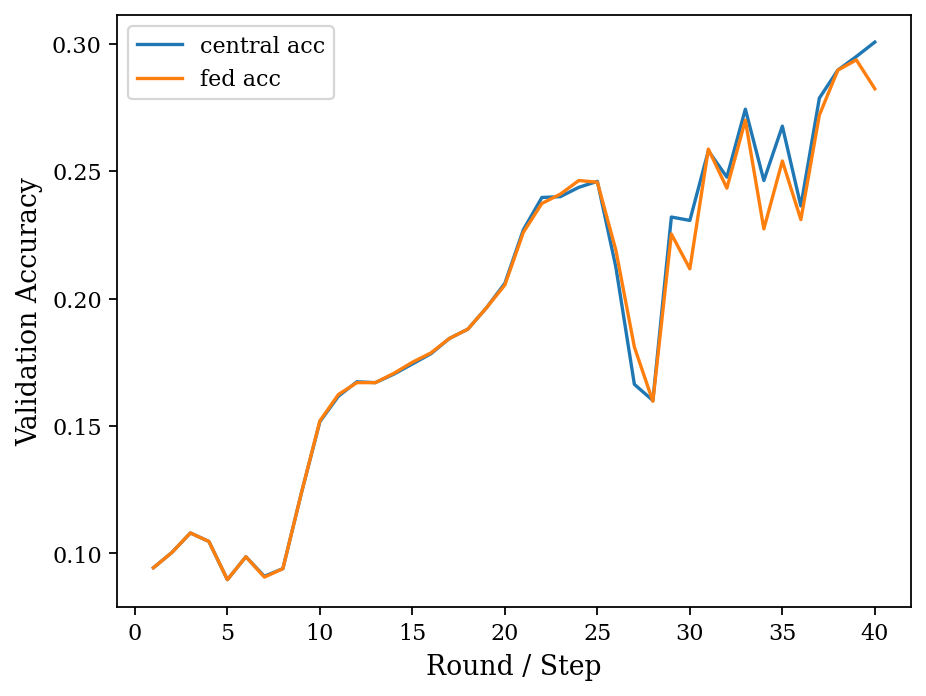

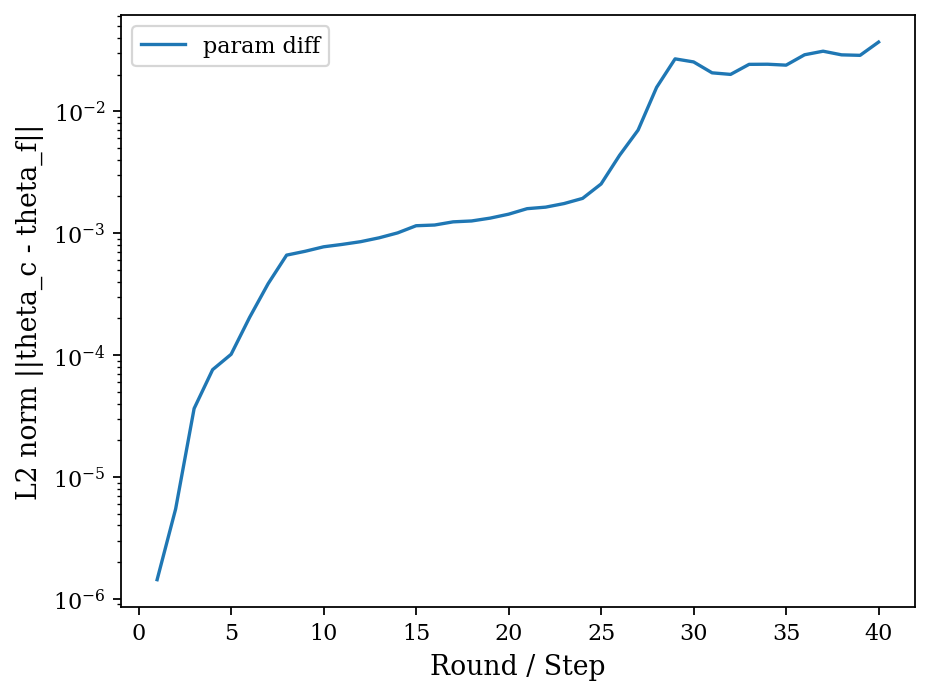

In [21]:
# plotting
rounds = list(range(1, NUM_ROUNDS + 1))
plt.figure()
plt.plot(rounds, history['central_loss'], label='central loss')
plt.plot(rounds, history['fed_loss'], label='fed loss')
plt.legend()
plt.xlabel("Round / Step")
plt.ylabel("Validation Loss")
plt.savefig('fedsgd_results/loss.png')

plt.figure()
plt.plot(rounds, history['central_acc'], label='central acc')
plt.plot(rounds, history['fed_acc'], label='fed acc')
plt.legend()
plt.xlabel("Round / Step")
plt.ylabel("Validation Accuracy")
plt.savefig('fedsgd_results/acc.png')

plt.figure()
plt.plot(rounds, history['param_diff'], label='param diff')
plt.yscale('log')
plt.legend()
plt.xlabel("Round / Step")
plt.ylabel("L2 norm ||theta_c - theta_f||")
plt.savefig('fedsgd_results/param_diff.png')
print("Saved plots to fedsgd_results/*.png")

# Task 2: Implementing FedAvg

### We use the same  dataset  and  model  from the previous task

In [11]:
def load_data(total_samples=10000, train_frac=0.8):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                             std=(0.2470, 0.2435, 0.2616))
    ])

    train_full = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    #  subset of training set
    indices = np.arange(len(train_full))
    np.random.shuffle(indices)
    sel = indices[:total_samples]

    # Stack images into tensors
    X = torch.stack([train_full[i][0] for i in sel])
    y = torch.tensor([train_full[i][1] for i in sel], dtype=torch.long)

    # Train/validation split
    perm = torch.randperm(total_samples)
    n_train = int(total_samples * train_frac)

    train_idx = perm[:n_train]
    val_idx   = perm[n_train:]

    X_train_full = X[train_idx].clone()
    y_train_full = y[train_idx].clone()

    X_test = X[val_idx].clone()
    y_test = y[val_idx].clone()

    return (X_train_full, y_train_full), (X_test, y_test)


#  subset of CIFAR-10
total_samples = 10000  
train_frac = 0.8
(X_train_full, y_train_full), (X_test, y_test) = load_data(total_samples, train_frac)


#  number of clients and split data
NUM_CLIENTS = 5
per_client = len(X_train_full) // NUM_CLIENTS
client_datasets = []
for i in range(NUM_CLIENTS):
    start = i*per_client
    end = (i+1)*per_client if i < NUM_CLIENTS-1 else len(X_train_full)
    client_datasets.append(TensorDataset(X_train_full[start:end], y_train_full[start:end]))

# Test loader
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle =False)

In [12]:
# utility func.
def copy_state(model):
    return {k:v.clone().cpu() for k,v in model.state_dict().items()}

def load_state_to_model(model, state):
    model.load_state_dict({k:v.clone() for k,v in state.items()})

def state_to_vector(state):
    return torch.cat([v.view(-1) for k,v in sorted(state.items())])

def l2_state_diff(state_a, state_b):
    return torch.norm(state_to_vector(state_a)-state_to_vector(state_b)).item()

def evaluate_model_state(state, loader):
    model = SmallCNN().to(DEVICE)
    load_state_to_model(model, state)
    model.eval()
    correct, total, loss_sum = 0,0,0.0
    crit = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb,yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss_sum += crit(logits,yb).item()
            correct += (logits.argmax(dim=1)==yb).sum().item()
            total += yb.size(0)
    return loss_sum/total, correct/total

### Local Client Training (K Epochs)

In [13]:
def local_train_state(global_state, client_dataset, local_epochs=5, batch_size=64):
    model = SmallCNN().to(DEVICE)
    load_state_to_model(model, global_state)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
    crit = nn.CrossEntropyLoss()
    for _ in range(local_epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            optimizer.step()
    return copy_state(model)

# Server Aggregation
def server_aggregate(client_states, client_sizes):
    total = sum(client_sizes[i] for i,_ in client_states)
    all_keys = list(client_states[0][1].keys())
    agg = {}
    for key in all_keys:
        if 'num_batches_tracked' in key:
            agg[key] = client_states[0][1][key].clone()  
        else:
            agg[key] = torch.zeros_like(client_states[0][1][key])
            for i, state in client_states:
                w = client_sizes[i] / total
                agg[key] += state[key] * w
    return {k: agg[k].cpu() for k in agg}

In [14]:
# FedAvg Runner
def run_fedavg(K=5, f=1.0, rounds=20):
    N = len(client_datasets)
    client_sizes = {i: len(client_datasets[i]) for i in range(N)}

    #  global model
    torch.manual_seed(SEED)
    global_model = SmallCNN().to(DEVICE)
    global_state = copy_state(global_model)

    logs = {'round':[], 'test_acc':[], 'avg_drift':[], 'comm_bytes':[], 'per_client_train_accs':[]}
    num_params = sum(p.numel() for p in global_model.parameters())
    bytes_per_param = 4  

    for t in range(1, rounds+1):
        m = max(1,int(round(f*N)))
        sampled = random.sample(range(N), m) if f<1.0 else list(range(N))

        client_states = []
        drifts = []
        for cid in sampled:
            st = local_train_state(global_state, client_datasets[cid], local_epochs=K)
            client_states.append((cid, st))
            drifts.append(l2_state_diff(st, global_state))

        global_state = server_aggregate(client_states, client_sizes)
        
        _, test_acc = evaluate_model_state(global_state, test_loader)
        avg_drift = float(np.mean(drifts))
        comm_bytes_round = num_params*bytes_per_param*len(sampled)

        per_client_accs = []
        for cid in range(N):
            _, acc_c = evaluate_model_state(global_state, DataLoader(client_datasets[cid], batch_size=256))
            per_client_accs.append(acc_c)

        logs['round'].append(t)
        logs['test_acc'].append(test_acc)
        logs['avg_drift'].append(avg_drift)
        logs['comm_bytes'].append(comm_bytes_round)
        logs['per_client_train_accs'].append(per_client_accs)

        print(f"[Round {t}] f={f:.2f}, K={K}: test_acc={test_acc:.4f}, avg_drift={avg_drift:.4e}, sampled={len(sampled)}")
    return logs

### Experiments

In [17]:
# 1. Vary K (full participation f=1)
K_values = [1,5,10,20]
results_vary_K = {}
for K in K_values:
    print("\nExperiment: varying K =", K)
    results_vary_K[K] = run_fedavg(K=K, f=1.0)

# 2. Vary f (client sampling)
f_values = [1.0,0.5,0.2]
K_fixed = 5
results_vary_f = {}
for f in f_values:
    print("\nExperiment: varying f =", f)
    results_vary_f[f] = run_fedavg(K=K_fixed, f=f)


Experiment: varying K = 1
[Round 1] f=1.00, K=1: test_acc=0.2300, avg_drift=2.7470e+00, sampled=5
[Round 2] f=1.00, K=1: test_acc=0.3475, avg_drift=9.3309e-01, sampled=5
[Round 3] f=1.00, K=1: test_acc=0.3995, avg_drift=9.0676e-01, sampled=5
[Round 4] f=1.00, K=1: test_acc=0.4550, avg_drift=8.8018e-01, sampled=5
[Round 5] f=1.00, K=1: test_acc=0.4765, avg_drift=8.9255e-01, sampled=5
[Round 6] f=1.00, K=1: test_acc=0.4820, avg_drift=9.0208e-01, sampled=5
[Round 7] f=1.00, K=1: test_acc=0.5170, avg_drift=9.1401e-01, sampled=5
[Round 8] f=1.00, K=1: test_acc=0.5210, avg_drift=9.8027e-01, sampled=5
[Round 9] f=1.00, K=1: test_acc=0.5310, avg_drift=9.7404e-01, sampled=5
[Round 10] f=1.00, K=1: test_acc=0.5500, avg_drift=1.0058e+00, sampled=5
[Round 11] f=1.00, K=1: test_acc=0.5375, avg_drift=1.0773e+00, sampled=5
[Round 12] f=1.00, K=1: test_acc=0.5600, avg_drift=1.0334e+00, sampled=5
[Round 13] f=1.00, K=1: test_acc=0.5570, avg_drift=1.1036e+00, sampled=5
[Round 14] f=1.00, K=1: test_acc=

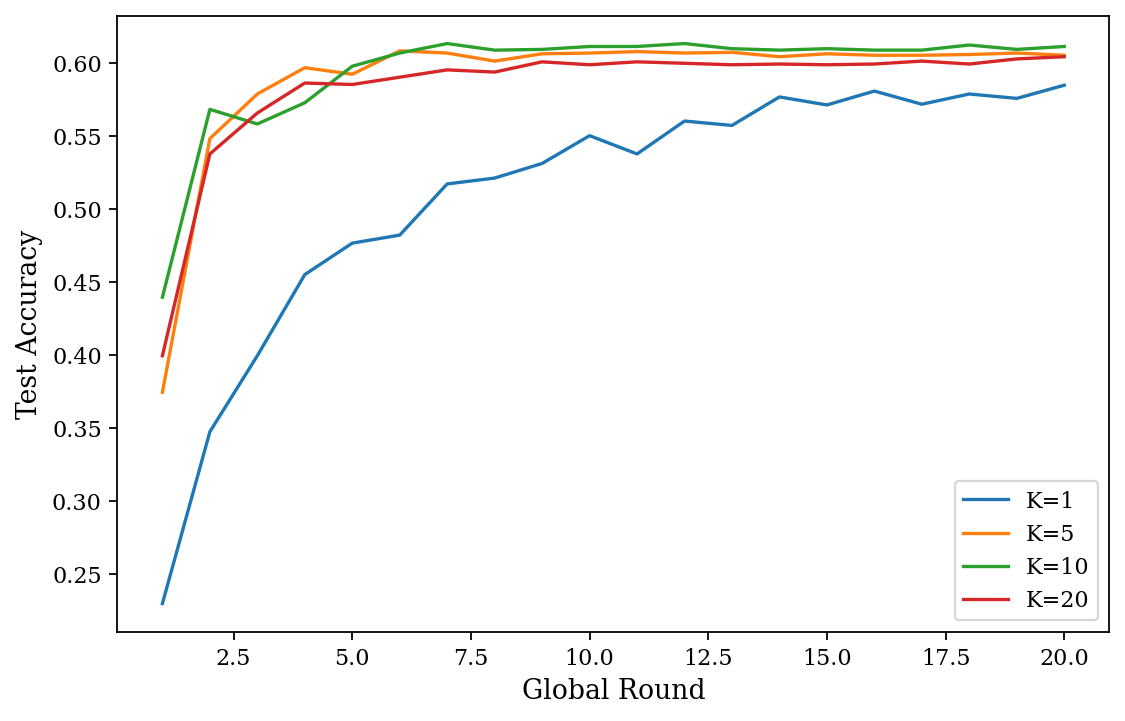

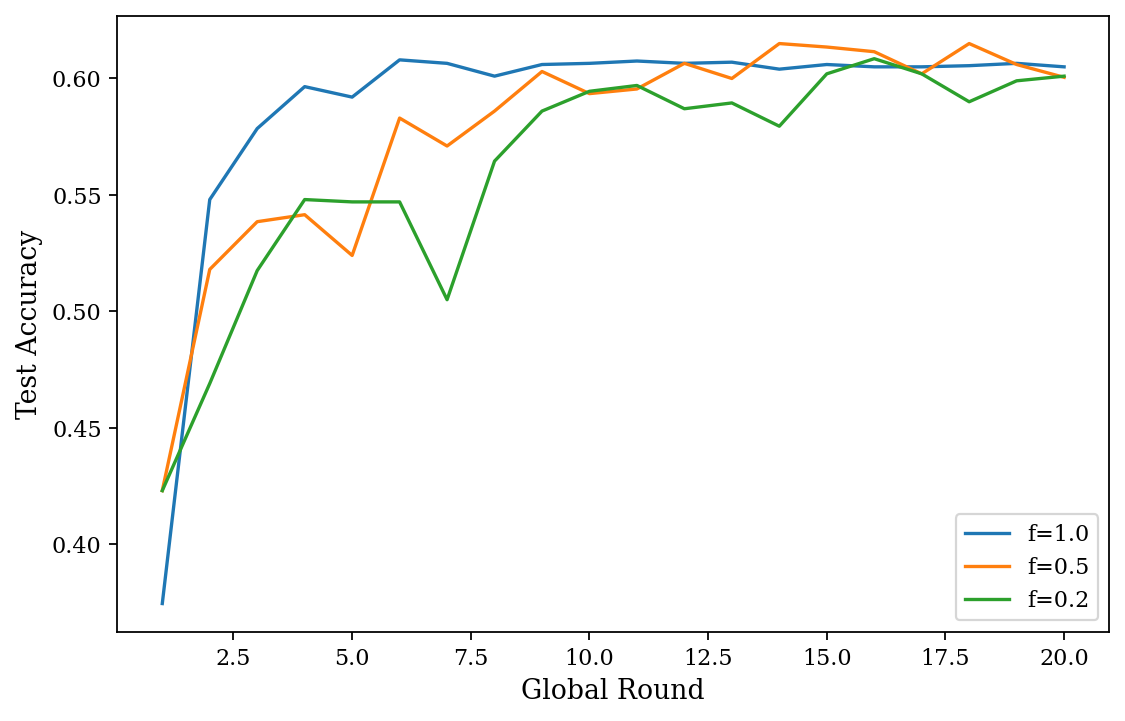

In [24]:
def plot_varyK(results_vary_K):
    plt.figure(figsize=(8,5))
    for K, logs in results_vary_K.items():
        plt.plot(logs['round'], logs['test_acc'], label=f"K={K}")
    plt.xlabel("Global Round")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.savefig("FedAvg: Varying K (full participation).png")
    plt.show()

def plot_varyf(results_vary_f):
    plt.figure(figsize=(8,5))
    for f, logs in results_vary_f.items():
        plt.plot(logs['round'], logs['test_acc'], label=f"f={f}")
    plt.xlabel("Global Round")
    plt.ylabel("Test Accuracy")
    plt.legend()
    plt.savefig("FedAvg: Varying Client Sampling Fraction f.png")
    plt.show()

plot_varyK(results_vary_K)
plot_varyf(results_vary_f)